<h1 style="font-family:times new roman;"> <center>Content Based Book Recommender</center> </h1>

<p><center style="color:#159364; font-family:times new roman; font-size:16px">Simple book recommender system using Python. </center></p>

***

<h2 style='font-family:times new roman'>Introduction</h2>

<p style='font-size:16px;font-family:times new roman'>The ways in which we can access content is growing at a rapid pace. With all of the various streaming platforms available to us, it can be argued that what sets a streaming service over another is its ability to recommend content to viewers and keep them on their websites or apps longer. Content based recommenders suggest similar titles for viewers based on their history. Generally it makes sense to recommend a tv show or book to someone because it is similar to something they already like. Using a dataset containing thousands of rows of data about books such as title, author, user rating, and user demographics, a simple recommendation system will be created.</p>

<h2 style='font-family:times new roman'>Data</h2>

<p style='font-size:16px;font-family:times new roman'>The datasets in this analysis are publicly available through Kaggle [1]. The Goodreads dataset is comprised of information on books gathered with the use of Goodread’s Api. The user reviews dataset contains ratings and reviews about 270k books from 278,858 anonymized users.</p>

<h2 style='font-family:times new roman'>Setting Up Enviroment</h2>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings  
warnings.filterwarnings('ignore')

<p style='font-size:16px;font-family:times new roman'>Import dataset and create a pandas dataframe.</p>

In [2]:
books_df = pd.read_csv('../input/bookcrossing-dataset/Books Data with Category Language and Summary/Preprocessed_data.csv')

<h2 style='font-family:times new roman'>Cleaning Data</h2>

<p style='font-size:16px;font-family:times new roman'>Preview dataset.</p>

In [3]:
books_df.head(5)
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Unnamed: 0           1031175 non-null  int64  
 1   user_id              1031175 non-null  int64  
 2   location             1031175 non-null  object 
 3   age                  1031175 non-null  float64
 4   isbn                 1031175 non-null  object 
 5   rating               1031175 non-null  int64  
 6   book_title           1031175 non-null  object 
 7   book_author          1031175 non-null  object 
 8   year_of_publication  1031175 non-null  float64
 9   publisher            1031175 non-null  object 
 10  img_s                1031175 non-null  object 
 11  img_m                1031175 non-null  object 
 12  img_l                1031175 non-null  object 
 13  Summary              1031175 non-null  object 
 14  Language             1031175 non-null  object 
 15

<p style='font-size:16px;font-family:times new roman'>Subsetting dataframe for books in english.</p>

In [4]:
books_df['Language'].unique()
books_eng = books_df[books_df['Language'] == 'en']

<p style='font-size:16px;font-family:times new roman'>Checking for nulls.</p>

In [5]:
books_eng.isnull().sum()

Unnamed: 0                 0
user_id                    0
location                   0
age                        0
isbn                       0
rating                     0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_s                      0
img_m                      0
img_l                      0
Summary                    0
Language                   0
Category                   0
city                    7765
state                  12121
country                21044
dtype: int64

<p style='font-size:16px;font-family:times new roman'>Changing all column names to lowercase.</p>

In [6]:
books_eng.columns = books_eng.columns.str.lower()

<p style='font-size:16px;font-family:times new roman'>Dropping columns that are not needed for the analysis.</p>

In [7]:
books_eng = books_eng.drop(columns =['unnamed: 0','img_s','img_m','img_l','language'])

<p style='font-size:16px;font-family:times new roman'>Changing data types.</p>

In [8]:
books_eng['year_of_publication']=books_eng['year_of_publication'].astype(int)
books_eng['age'] = books_eng['age'].astype(int)

<h2 style='font-family:times new roman'> Exploratory Analysis</h2>

<p style = 'font-size:16px;font-family:times new roman'>What are the top books in this dataset? First, the dataset is aggregated to find the number of ratings each book receives as well as their average rating. It is important to distinguish between the books with the highest number of ratings and the books with the highest ratings. The graph shows that <i> Wild Animus </i> has received the most ratings from users, yet it is rated extremely low with an average user rating of 1.01.<p>

In [9]:
# # Find the number of ratings for each book.
num_ratings = books_eng.groupby('book_title', as_index=False)['rating'].count()

num_ratings = num_ratings.rename(columns={'rating': 'num_of_ratings'})

most_ratings = num_ratings.sort_values(
    by='num_of_ratings', ascending=False).head(10)

In [10]:
# # Color palette.
my_color_pal = [
    'MediumSeaGreen',
    'LightSeaGreen',
    'MediumAquaMarine',
    'LightSkyBlue',
    'LightSteelblue',
    'PowderBlue',
    'Plum',
    'LightSalmon',
    'LightPink',
    'Moccasin',
]

Text(0.5, 0, 'Number of Ratings')

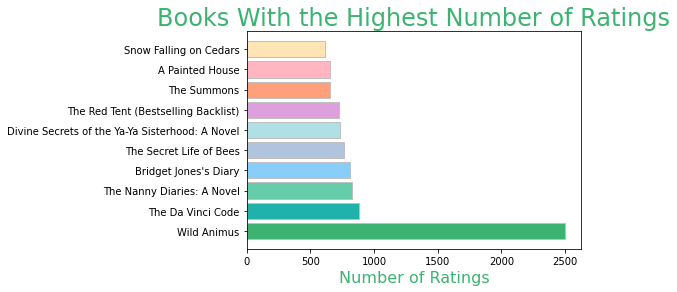

In [11]:
y = most_ratings['book_title']
width = most_ratings['num_of_ratings']
most_viz = plt.barh(y, width, color=my_color_pal, edgecolor='silver')
plt.title('Books With the Highest Number of Ratings',
          fontsize=24, color='MediumSeaGreen')
plt.xlabel('Number of Ratings', fontsize=16, color='MediumSeaGreen')

<p style='font-size:16px;font-family:times new roman'>In this dataset, the books with the largest number of ratings are not the books with the highest ratings. The highest rated book, Donna Kooler’s <i>555 Christmas Cross-Stitch Designs</i>, only has two ratings, so deeming it the top book would be inaccurate.</p>

In [12]:
avg_ratings = books_eng.groupby('book_title', as_index=False)['rating'].mean()

avg_ratings = avg_ratings.rename(columns={'rating': 'avg_rating'})

avg_ratings.sort_values(by='avg_rating', ascending=False).head(3)

,book_title,avg_rating
27444,Donna Kooler's 555 Christmas Cross-Stitch Designs,10.0
28055,Drawing for the Artistically Undiscovered,10.0
91272,The Book of Job,10.0


<p style='font-size:16px;font-family:times new roman'>When the data frame is sorted by the number of ratings from highest to lowest, the top twenty books have 470 or more ratings. To find the top books, the data frame is subset for the books with 470 or more ratings. This can help determine which books are rated the highest while also having a significant number of ratings.</p>

In [13]:
ratings = num_ratings.merge(avg_ratings, how='inner', on='book_title')
ratings['num_of_ratings'].sort_values(ascending=False).head(20)

123495    2502
94208      886
103805     828
15243      815
108227     768
26855      732
106914     723
109970     654
3063       652
82403      618
110452     615
40730      571
4078       542
109856     542
115441     531
37710      526
47555      506
99243      506
92900      480
38580      470
Name: num_of_ratings, dtype: int64

In [14]:
ratings_over_470 = ratings[ratings['num_of_ratings'] >= 470]

top_books = ratings_over_470.sort_values(
    by='avg_rating', ascending=False).head(10)

In [15]:
# # Shortening titles.
top_books.iloc[0, 0] = "Harry Potter and the Sorcerer's Stone"
top_books.iloc[3, 0] = 'The Red Tent'
top_books.iloc[8, 0] = 'The Nanny Diaries'

<p style='font-size:16px;font-family:times new roman'>The scatter plot shows that <i>Harry Potter and the Sorcerer’s Stone</i> has the highest average rating of 4.9 with approximately 500 users leaving a rating. While <i>The Da Vinci Code </i> received 886 ratings and has an average rating of 4.6.</p>

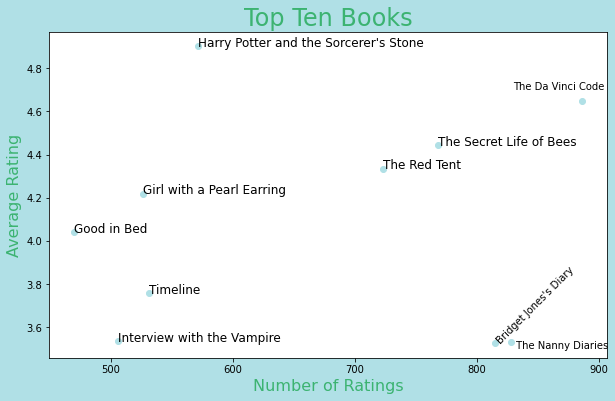

In [16]:
x = list(top_books['num_of_ratings'])
y = list(top_books['avg_rating'])
labels = list(top_books['book_title'])

fig = plt.figure(facecolor = 'PowderBlue',figsize = (10, 6))
plt.scatter(x, y, c='PowderBlue')
plt.title('Top Ten Books', fontsize=24, color='MediumSeaGreen')
plt.xlabel('Number of Ratings', fontsize=16, color='MediumSeaGreen')
plt.ylabel('Average Rating', fontsize=16, color='MediumSeaGreen')
for i, txt in enumerate(labels):
    if i == 9:
        plt.annotate(txt, (x[i], y[i]), rotation=45, size=10)
    elif i == 8:
        txt = ' {t}'.format(t=txt)
        plt.annotate(txt, (830, 3.5), size=10)
    elif i == 1:
        plt.annotate(txt, (830, 4.7), size=10)
    else:
        plt.annotate(txt, (x[i], y[i]), size=12)
plt.show()

<p style='font-size:16px;font-family:times new roman'>In addition to finding the top-rated books, this dataset can be used to identify some basic demographic information on those who left ratings. Exploring the age ranges for the users can be insightful especially when applied to the most popular books in the dataset.</p>

<p style='font-size:16px;font-family:times new roman'>Three books were chosen to delve deeper into the demographic of the readers. <i>Harry Potter and the Sorcerer's Stone</i> is the highest rated book with a significant number of ratings. <i> The Da Vinci Code </i> is close behind Harry Potter in terms of popularity, with an average rating of 4.6 and approximately 900 ratings. <i>Wild Animus</i> is the book with the largest number of ratings, 2502, however it is also one of the lowest rated with an average rating of 1.0.</p>

In [17]:
# # Subset dataframe for users that rated harry potter.
hp_readers = books_eng[books_eng['book_title'] ==
                       "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"]

# # Age ranges for harry potter readers.
hp_age = hp_readers.groupby('age', as_index=False)['user_id'].nunique()

# # Create a new dataframe with age ranges.
columns = ['age_range', 'Harry Potter', 'The Da Vinci Code', 'Wild Animus']
age_ranges = pd.DataFrame(index=[0, 1, 2, 3], columns=columns)

eighteen_under, thirty_under, thirty_five_under, thirty_five_plus = 0, 0, 0, 0
for index, row in hp_readers.iterrows():
    if row['age'] in range(12, 19):
        eighteen_under += 1
    elif row['age'] in range(19, 30):
        thirty_under += 1

    elif row['age'] in range(30, 36):
        thirty_five_under += 1

    elif row['age'] >= 36:
        thirty_five_plus += 1

age_ranges['age_range'].iloc[0] = '12-18'
age_ranges['age_range'].iloc[1] = '19-29'
age_ranges['age_range'].iloc[2] = '30-35'
age_ranges['age_range'].iloc[3] = '36+'

# # Find the percentage of users that fall within each age range.
age_ranges['Harry Potter'].iloc[0] = round(
    eighteen_under/len(hp_readers)*100, 1)
age_ranges['Harry Potter'].iloc[1] = round(thirty_under/len(hp_readers)*100, 1)
age_ranges['Harry Potter'].iloc[2] = round(
    thirty_five_under/len(hp_readers)*100, 1)
age_ranges['Harry Potter'].iloc[3] = round(
    thirty_five_plus/len(hp_readers)*100, 1)


In [18]:
# # The Da Vinci Code.
da_readers = books_eng[books_eng['book_title'] == "The Da Vinci Code"]

# # Age ranges for The Da Vinci Code Readers.
da_age = da_readers.groupby('age', as_index=False)['user_id'].nunique()

# # Same process repeated for The Da Vinci Code.
eighteen_under, thirty_under, thirty_five_under, thirty_five_plus = 0, 0, 0, 0
for index, row in da_readers.iterrows():
    if row['age'] in range(12, 19):
        eighteen_under += 1
    elif row['age'] in range(19, 30):
        thirty_under += 1

    elif row['age'] in range(30, 36):
        thirty_five_under += 1

    elif row['age'] >= 36:
        thirty_five_plus += 1

age_ranges['The Da Vinci Code'].iloc[0] = round(
    eighteen_under/len(da_readers)*100, 1)
age_ranges['The Da Vinci Code'].iloc[1] = round(
    thirty_under/len(da_readers)*100, 1)
age_ranges['The Da Vinci Code'].iloc[2] = round(
    thirty_five_under/len(da_readers)*100, 1)
age_ranges['The Da Vinci Code'].iloc[3] = round(
    thirty_five_plus/len(da_readers)*100, 1)

In [19]:
# # Wild Animus
wa_readers = books_eng[books_eng['book_title'] == "Wild Animus"]

# # Age ranges for Wild Animus.
wa_age = wa_readers.groupby('age', as_index=False)['user_id'].nunique()


eighteen_under, thirty_under, thirty_five_under, thirty_five_plus = 0, 0, 0, 0
for index, row in wa_readers.iterrows():
    if row['age'] in range(12, 19):
        eighteen_under += 1
    elif row['age'] in range(19, 30):
        thirty_under += 1

    elif row['age'] in range(30, 36):
        thirty_five_under += 1

    elif row['age'] >= 36:
        thirty_five_plus += 1

age_ranges['Wild Animus'].iloc[0] = round(
    eighteen_under/len(wa_readers)*100, 1)
age_ranges['Wild Animus'].iloc[1] = round(thirty_under/len(wa_readers)*100, 1)
age_ranges['Wild Animus'].iloc[2] = round(
    thirty_five_under/len(wa_readers)*100, 1)
age_ranges['Wild Animus'].iloc[3] = round(
    thirty_five_plus/len(wa_readers)*100, 1)

<p style='font-size:16px;font-family:times new roman'> The data reveals that for Harry Potter, 41% of readers that left a rating, fall within the age range of 30-35. <i>The Da Vinci Code</i> has a similar split in age range as Harry Potter, with nearly 80% of its readers being over the age of 30. Interestingly, the lowest rated book, <i>Wild Animus</i> has an even distribution in the ranges over 18. It seems amongst nearly all ages; <i>Wild Animus</i> is disliked. It almost makes me want to read to it and find out why.</p>

In [20]:
age_ranges

,age_range,Harry Potter,The Da Vinci Code,Wild Animus
0,12-18,6.5,1.6,6.2
1,19-29,26.3,21.7,30.3
2,30-35,41.5,39.1,30.2
3,36+,25.0,37.7,33.2


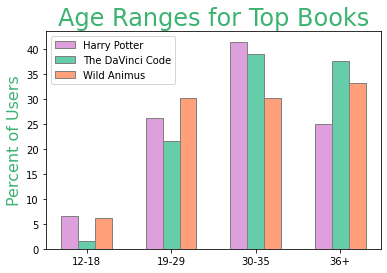

In [21]:
HarryPotter = list(age_ranges['Harry Potter'])
TheDaVinciCode = list(age_ranges['The Da Vinci Code'])
WildAnimus = list(age_ranges['Wild Animus'])
x = list(age_ranges['age_range'])
_x = np.arange(len(x))

plt.bar(_x - 0.2, HarryPotter, width=0.2, color='Plum',
        edgecolor='Gray', label='Harry Potter')
plt.bar(_x, TheDaVinciCode, width=0.2, color='MediumAquaMarine',
        edgecolor='Gray', label='The DaVinci Code')
plt.bar(_x + 0.2, WildAnimus, width=0.2, color='LightSalmon',
        edgecolor='Gray', label='Wild Animus')
plt.xticks(_x, x)
plt.title('Age Ranges for Top Books', fontsize=24, color='MediumSeaGreen')
plt.ylabel('Percent of Users', fontsize=16, color='MediumSeaGreen')
plt.legend()
plt.show()

<h2 style='font-family:times new roman'>Recommender System</h2>

<p style='font-size:16px;font-family:times new roman'>Content based recommenders work by suggesting items similar to a particular item using that item’s metadata. For this dataset, the book’s summary column will be used to create a simple recommendation system. This method follows <a href="https://www.datacamp.com/community/tutorials/recommender-systems-python">Aditya Sharma’s DataCamp tutorial</a> [2].</p>

<p style='font-size:16px;font-family:times new roman'>First, step is to create a new dataframe with the book titles and the summaries. NOTE: The dataset was truncated to 200k results because using sklearn's cosine similarity function required to much memory with the full dataset.</p>

In [22]:

book_summary = books_eng[1:200000].groupby(['book_title', 'summary'], as_index=False)[
    'rating'].mean()

book_summary['book_title'].drop_duplicates(inplace=True)
book_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7525 entries, 0 to 7524
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   book_title  7525 non-null   object 
 1   summary     7525 non-null   object 
 2   rating      7525 non-null   float64
dtypes: float64(1), object(2)
memory usage: 235.2+ KB


<p style='font-size:16px;font-family:times new roman'>This removes words that do not provide any useful information about the topic like 'the'.</p>

In [23]:
tfidf = TfidfVectorizer(stop_words='english')

<p style='font-size:16px;font-family:times new roman'>Replacing null values with an empty string.</p>

In [24]:
book_summary['summary'] = book_summary['summary'].fillna('')

<p style='font-size:16px;font-family:times new roman'>Using scikit-learn TfIdfVectorizer class a Term Frequency-Inverse Document Frequency matrix will be created. Word vectorization is natural language processing tool that allows for words to be assigned to corresponding vector of real numbers. This can then be used find similarities in texts [3].</p>

In [25]:
# # Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(book_summary['summary'])

# # Compute the cosine similarity matrix.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Construct a reverse map of indices and book titles.
indices = pd.Series(book_summary.index,
                    index=book_summary['book_title']).drop_duplicates()


In [26]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(book_summary.index,
                    index=book_summary['book_title']).drop_duplicates()



<p style='font-size:16px;font-family:times new roman'>The recommendation function takes a book’s title (that’s within the dataset) as a parameter. It will get the index of the book and get a list of the cosine similarity scores for that specific book and the rest of the books in the dataset. The list will be sorted based on the similarity scores, and the top five most similar books will be returned.</p>

In [27]:

def get_recommendations(book_title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[book_title]

    # Similarity scores
    similarity_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the six most similar books
    similarity_scores =  similarity_scores[1:6]

    # Get the book indices
    book_indices = [i[0] for i in similarity_scores]

    # Return the top 10 most similar books
    return book_summary['book_title'].iloc[book_indices]

<p style='font-size:16px;font-family:times new roman'>When <i>Harry Potter and the Sorcerer's Stone'</i> is parsed throught the get_recommendations function, a list of other Harry Potter books are returned. It makes sense that readers of the first series would want to read the other books in the series. This recommendation system could be improved by using the book's genre, author, setting, etc to find more similarities between books.</p>

In [28]:
get_recommendations("Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))")

2306    Harry Potter and the Sorcerer's Stone (Harry P...
2304       Harry Potter and the Sorcerer's Stone (Book 1)
2300         Harry Potter and the Goblet of Fire (Book 4)
2301    Harry Potter and the Order of the Phoenix (Boo...
2303    Harry Potter and the Prisoner of Azkaban (Book 3)
Name: book_title, dtype: object

<p style='font-size:16px;font-family:times new roman'><i>The Da Vinci Code</i> probably yield the most obvious recommendations. Since 'Da Vinci' is a unique phrase that would only be included in a book's summary if the book was about the artist, it is expected that most of the books recommended would be just that.</p>

In [29]:
get_recommendations('The Da Vinci Code')

5427         The Da Vinci Code (Random House Large Print)
2008    Fortune Is a River : Leonardo Da Vinci and Nic...
604                                               Baggage
5809    The How to Think Like Leonardo da Vinci Workbo...
2215    Great Book Of Whodunit Puzzles: Mini-Mysteries...
Name: book_title, dtype: object

<p style='font-size:16px;font-family:times new roman'>It seems that <i>Wild Animus</i> may have yield the best results. Wild Animus is categorized as a philosophical/psychological novel that involves a man going through a journey. The list of books recommended seem to be spiritual and philosophical books as well.</p>

In [30]:
get_recommendations('Wild Animus')

4419                                 Second Ring of Power
2169         Godel, Escher, Bach: An Eternal Golden Braid
859     Breaking Down the Wall of Silence: The Liberat...
5497                                    The Dog I.Q. Test
7367    Wild Man's Journey: Reflections on Male Spirit...
Name: book_title, dtype: object

<h2 style='font-family:times new roman'>Conclusion</h2>

<p style='font-size:16px;font-family:times new roman'>The ability for websites and streaming platforms to keep recommend new content to their customers is very important. The rate at which content is produced means that choosing what tv show to watch or what book to read can be overwhelming. A streaming service can have millions of choices for viewers to enjoy, but ultimately that just makes selecting content the more difficult. However, if streaming services can focus on curating personalized content for their customers, it could be the difference between someone watching an entire series or someone getting frustrated at not finding something to watch and moving on to another platform.</p>

<h2 style='font-family:times new roman'>References</h2>

1. [Ruchi Bhatia's Book: User Review Ratings Dataset(11 Aug 2020)](https://www.kaggle.com/ruchi798/bookcrossing-dataset/metadata)
2. [Aditya Sharma's Book Recommender Tutorial on Datacamp(29 May 2020)](https://www.datacamp.com/community/tutorials/recommender-systems-python)
3. [Prahbu's Understanding NLP Word Embeddings on towardsdatascience(11 Nov 2019)](https://towardsdatascience.com/understanding-nlp-word-embeddings-text-vectorization-1a23744f7223)